1. Read in CMIP6 model data 
2. Read in ETCCDI data 
3. Make sure on same grid, time etc. 
4. Calculate composites for variables (take multi model mean at end)
5. Sign comparison between mean and extreme for each variable (for mmm)

In [1]:
# 0. Imports 
import xarray as xr
import numpy as np
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import dask
dask.config.set({'array.slicing.split_large_chunks': False})

In [2]:
# 1. Read in CMIP6 model data 
data = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_ts_quad_detrend_1900_2015.nc')

In [4]:
# 2. Read in ETCCDI data 
# Use base independent 
# Bases are only for percentile based indices 
# TXx, TNn and Rx1day all base independant indices 
regrid_paths = '/g/data/w40/rl5183/CMIP6_ETCCDI_txx_regrid/*'
ds = xr.open_mfdataset(regrid_paths, combine='nested', concat_dim='model', chunks={'time':-1, 'lat':110, 'lon':110})
ds.coords['model'] = data.model
txx = ds.txxETCCDI.sel(time=slice('1900-01', '2014-12'))

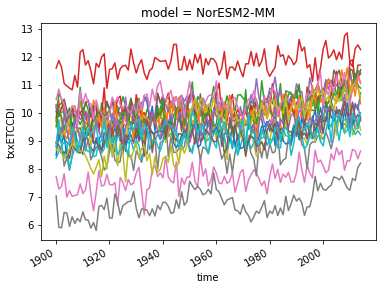

In [5]:
# Check trends 

#for m in txx.model:
    #melb = txx.sel(model=m).sel(lat=-37.8, method='nearest').sel(lon=144, method='nearest')
    #melb.isel(time=slice(0,None,12)).plot()
    
#for m in txx.model:
    #aus = txx.sel(model=m).sel(lat=slice(-43, -10)).sel(lon=slice(113, 153))
    #aus.isel(time=slice(0,None,12)).mean(dim=['lat', 'lon']).plot()
    
#for m in txx.model:
    #aus = txx.sel(model=m).sel(lat=slice(-43, -10)).sel(lon=slice(113, 153))
    #aus.isel(time=-1).plot(figsize=(5,5))

for m in txx.model:
    glob = txx.sel(model=m).mean(dim=['lat', 'lon'])
    glob.isel(time=slice(0,None,12)).plot()

In [6]:
# Detrend TXx using quadtratic detrend since above graph doesn't look linear
txx_dt = xr.apply_ufunc(func.quad_detrend, txx, 
                             input_core_dims=[['time']],
                             output_core_dims=[['time']],
                             vectorize=True,
                             dask='parallelized')

txx_dt = txx_dt.transpose(*txx.dims).chunk('auto')

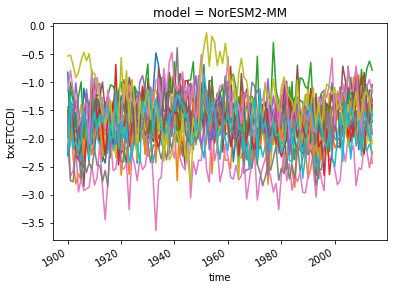

In [7]:
for m in txx_dt.model:
    glob = txx_dt.sel(model=m).mean(dim=['lat', 'lon'])
    glob.isel(time=slice(0,None,12)).plot()
    
#for m in txx_dt.model:
    #aus = txx_dt.sel(model=m).sel(lat=slice(-43, -10)).sel(lon=slice(113, 153))
    #aus.isel(time=-1).plot(figsize=(5,5))

In [8]:
# Calculate Nino3.4 index
nino34_list = []
for m in data.model:
    nino34_list.append(func.nino34_index(data.sel(model=m), '1950-01', '1979-12'))
nino34 = xr.DataArray(nino34_list, dims=['model', 'time'], coords=[data.model, data.time])

In [9]:
elnino_list_txx = []
lanina_list_txx = []
for m in nino34.model:
    el, la = func.sst_comp(nino34.sel(model=m), txx_dt.sel(model=m), 'DJF', 0.5, 6)
    elnino_list_txx.append(el)
    lanina_list_txx.append(la)
    
elnino_txx = xr.concat(elnino_list_txx, dim='model').chunk('auto')
lanina_txx = xr.concat(lanina_list_txx, dim='model').chunk('auto')

elnino_txx.to_netcdf('elnino_comp_txx_cmip6_20.nc')
lanina_txx.to_netcdf('lanina_comp_txx_cmip6_20.nc')

In [10]:
elnino_txx = xr.open_dataarray('elnino_comp_txx_cmip6_20.nc')
lanina_txx = xr.open_dataarray('lanina_comp_txx_cmip6_20.nc')